In [3]:
# import libraries

import pickle
import codecs
import numpy as np
import pandas as pd

from keras.layers import Embedding, Input, LSTM, Dense, Bidirectional,merge,Reshape, Lambda, Dropout,concatenate, Activation, GRU
from keras.models import Sequential, Model
from keras.layers.pooling import MaxPooling1D,AveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from keras.layers.core import Flatten

Using TensorFlow backend.


In [4]:
from keras import backend as K

K.set_learning_phase(1) #set learning phase

In [5]:
#constants and flags

embedding_dim = 100
max_len = 100

read_embedding = False

top_n =3

In [6]:
# read data

in_loc_qa_tuple = "/input/train_data.pkl"
in_loc_qa_tuple_test = "/input/test_data.pkl"

with open(in_loc_qa_tuple,'rb') as file_:
    train_data = pickle.load(file_)
    
with open(in_loc_qa_tuple_test,'rb') as file_:
    test_data = pickle.load(file_)

In [7]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [8]:
# drop duplicates in train and test data

train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [9]:
train_data.shape

(87423, 7)

In [10]:
train_data.head()

,0,1,2,3,4,5,6
0,to whom did the virgin mary allegedly appear i...,"it is a replica of the grotto at lourdes , fra...",immediately in front of the main building and ...,at the end of the main drive ( and in a direct...,1,0,0
1,what is in front of the notre dame main buildi...,next to the main building is the basilica of t...,"architecturally , the school has a catholic ch...",at the end of the main drive ( and in a direct...,0,0,0
2,the basilica of the sacred heart at notre dame...,next to the main building is the basilica of t...,immediately behind the basilica is the grotto ...,"architecturally , the school has a catholic ch...",1,0,0
3,what is the grotto at notre dame ?,"it is a replica of the grotto at lourdes , fra...",immediately behind the basilica is the grotto ...,"architecturally , the school has a catholic ch...",0,1,0
4,what sits on top of the main building at notre...,next to the main building is the basilica of t...,at the end of the main drive ( and in a direct...,atop the main building ' s gold dome is a gold...,0,0,1


In [11]:
limit =train_data.shape[0]

In [12]:
train_question = np.asarray(train_data[0])
train_sentence = np.array(train_data.iloc[:,1:top_n + 1])

In [13]:
test_question = np.asarray(test_data[0])
test_sentence = np.array(test_data.iloc[:,1:top_n + 1])

In [14]:
train_question.shape

(87423,)

In [15]:
lable_train = np.array(train_data.iloc[:,top_n + 1:])

In [16]:
lable_test = np.array(test_data.iloc[:,top_n + 1:])

In [17]:
single_train_question = []
single_train_sentence = []
single_train_lable = []

for i in range(len(train_question)):
    
    ans_i = np.argmax(lable_train[i])
    
    if lable_train[i][ans_i] == 1:
        single_train_question.append(train_question[i])
        single_train_question.append(train_question[i])
        single_train_question.append(train_question[i])
        single_train_question.append(train_question[i])
        
        
        if ans_i == 0:
            single_train_sentence.append(train_sentence[i][ans_i])
            single_train_sentence.append(train_sentence[i][ans_i + 1])
            single_train_sentence.append(train_sentence[i][ans_i])
            single_train_sentence.append(train_sentence[i][ans_i + 2])

        elif ans_i == 0:
            single_train_sentence.append(train_sentence[i][ans_i])
            single_train_sentence.append(train_sentence[i][ans_i - 1])
            single_train_sentence.append(train_sentence[i][ans_i])
            single_train_sentence.append(train_sentence[i][ans_i + 1])
            
        else:
            single_train_sentence.append(train_sentence[i][ans_i])
            single_train_sentence.append(train_sentence[i][ans_i - 2])
            single_train_sentence.append(train_sentence[i][ans_i])
            single_train_sentence.append(train_sentence[i][ans_i - 1])
            
            
        single_train_lable.append([1])
        single_train_lable.append([0])
        single_train_lable.append([1])
        single_train_lable.append([0])
     
    
single_train_question = np.array(single_train_question)
single_train_sentence = np.array(single_train_sentence)
single_train_lable = np.array(single_train_lable)

In [18]:
single_train_question[:10]

array([ 'to whom did the virgin mary allegedly appear in 1858 in lourdes france ?',
       'to whom did the virgin mary allegedly appear in 1858 in lourdes france ?',
       'to whom did the virgin mary allegedly appear in 1858 in lourdes france ?',
       'to whom did the virgin mary allegedly appear in 1858 in lourdes france ?',
       'the basilica of the sacred heart at notre dame is beside to which structure ?',
       'the basilica of the sacred heart at notre dame is beside to which structure ?',
       'the basilica of the sacred heart at notre dame is beside to which structure ?',
       'the basilica of the sacred heart at notre dame is beside to which structure ?',
       'what is the grotto at notre dame ?',
       'what is the grotto at notre dame ?'],
      dtype='<U279')

In [19]:
single_train_sentence[:10]

array([ 'it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 .',
       'immediately in front of the main building and facing it , is a copper statue of christ with arms upraised with the legend " venite ad me omnes " .',
       'it is a replica of the grotto at lourdes , france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858 .',
       'at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ) , is a simple , modern stone statue of mary .',
       'next to the main building is the basilica of the sacred heart .',
       'immediately behind the basilica is the grotto , a marian place of prayer and reflection .',
       'next to the main building is the basilica of the sacred heart .',
       'architecturally , the school has a catholic character .',
       'immediately behind the basilica is the grotto , a marian place of prayer and r

In [20]:
single_train_lable[:10]

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [21]:
single_test_question = []
single_test_sentence = []
single_test_lable = []

for i in range(len(test_question)):
    
    ans_i = np.argmax(lable_test[i])
    
    if lable_test[i][ans_i] == 1:
        single_test_question.append(test_question[i])
        single_test_question.append(test_question[i])
        single_test_question.append(test_question[i])
        single_test_question.append(test_question[i])
        
        if ans_i == 0:
            single_test_sentence.append(test_sentence[i][ans_i])
            single_test_sentence.append(test_sentence[i][ans_i + 1])
            single_test_sentence.append(test_sentence[i][ans_i])
            single_test_sentence.append(test_sentence[i][ans_i + 2])
        elif ans_i == 1:
            single_test_sentence.append(test_sentence[i][ans_i])
            single_test_sentence.append(test_sentence[i][ans_i - 1])
            single_test_sentence.append(test_sentence[i][ans_i])
            single_test_sentence.append(test_sentence[i][ans_i + 1])
            
        else:
            single_test_sentence.append(test_sentence[i][ans_i])
            single_test_sentence.append(test_sentence[i][ans_i - 2])
            single_test_sentence.append(test_sentence[i][ans_i])
            single_test_sentence.append(test_sentence[i][ans_i - 1])
            
        single_test_lable.append([1])
        single_test_lable.append([0])
        single_test_lable.append([1])
        single_test_lable.append([0])
     
    
single_test_question = np.array(single_test_question)
single_test_sentence = np.array(single_test_sentence)
single_test_lable = np.array(single_test_lable)

In [22]:
#get embedding index

def get_embedding_index():
    embeddings_index = {}
    f = codecs.open('/input/glove/glove.txt',encoding = 'utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    return embeddings_index

# get embedding matrix

def get_embedding_matrix(vocab):
    
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word in vocab:
        wi = vocab[word]
        
        if word == '<none>':
            continue
        if word not in glove2vec.keys():
            #print('warning: glove OOV', word)
            embedding_matrix[wi] = np.array(glove2vec['<unk>'])
        else:
            embedding_matrix[wi] = np.array(glove2vec[word])            
    
    return embedding_matrix

# create vocab

def create_vocab(data,vocab = None):
    
    if vocab is None:
        vocab = {
            '<none>': 0,
            '<unk>': 1
        }
    else:
        vocab = vocab
    
    def update_vocab(sentence):
        for word in sentence.split():
            if word in vocab:
                continue
            vocab[word] = len(vocab)
    
    for i,row in data.iterrows():
        for j in range(top_n+1):
            update_vocab(row[j])
    
    return vocab

In [23]:
glove2vec = get_embedding_index()
glove2vec['<unk>'] = [0] *100

In [24]:
vocab = create_vocab(train_data)
vocab = create_vocab(test_data,vocab)

In [25]:
len(vocab)

83451

In [26]:
embedding_matrix = get_embedding_matrix(vocab)

In [27]:
embedding_layer = Embedding(len(vocab),
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=True)

In [28]:
def padding(text):
    
    text_vector = [vocab[word] for word in text.split()]
    
    if len(text_vector) >= max_len:
        text_vector = text_vector[:max_len]
    else:
        text_vector =  [0] * (max_len - len(text_vector)) + text_vector
        
    return text_vector 

In [29]:
def prediction_accuracy(y_pred,y_actual):
    
    count = 0
    
    for i in range(0,len(y_actual),2):
        if y_pred[i] > y_pred[1 + i]:
            count+=2
            
    return count


In [30]:
def categorical_hinge(y_true, y_pred):
    pos = y_true * y_pred
    neg = (1.0 - y_true) * y_pred
    return K.maximum(0.0, neg - pos + 1)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def cos_distance(y):
    y_true, y_pred  = y
    def l2_normalize(x, axis):
        norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
        return K.sign(x) * K.maximum(K.abs(x), K.epsilon()) / K.maximum(norm, K.epsilon())
    y_true = l2_normalize(y_true, axis=-1)
    y_pred = l2_normalize(y_pred, axis=-1)
    
    return K.sum(y_true * y_pred, axis=-1)


In [31]:
from keras.layers.merge import Add
from keras.objectives import cosine_proximity

In [32]:
#build model
input_question = Input(shape=(max_len,))
input_sentence = Input(shape=(max_len,))

embedded_question = embedding_layer(input_question)
embedded_sentence = embedding_layer(input_sentence)
print(embedded_question.shape)


shared_lstm = Bidirectional(LSTM(64,dropout_W=0.3))


encoded_question = shared_lstm(embedded_question)
encoded_sentence = shared_lstm(embedded_sentence)
print(encoded_question.shape)

cnn_question = Conv1D(3000,filter_length = 2)(Reshape((128,1))(encoded_question))
cnn_sentence = Conv1D(3000,filter_length = 2)(Reshape((128,1))(encoded_sentence))
print(cnn_question.shape)

maxpool_question = MaxPooling1D(127)(cnn_question)
maxpool_sentence = MaxPooling1D(127)(cnn_sentence)
print(maxpool_question.shape)

maxpool_question = Activation('tanh')(maxpool_question)
maxpool_sentence = Activation('tanh')(maxpool_sentence)
print(maxpool_question.shape)


cos_similarity = Lambda(cos_distance,output_shape=cos_dist_output_shape)([maxpool_question,maxpool_sentence])
print(cos_similarity.shape)

model = Model([input_question, input_sentence], [cos_similarity])

learning_rate = 0.2
momentum = 0.9
decay = learning_rate/10

sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay, nesterov=False)

model.compile(sgd, loss = categorical_hinge)

(?, 100, 100)


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.3)`


(?, 128)
(?, 127, 3000)
(?, 1, 3000)
(?, 1, 3000)
(?, 1)


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(3000, kernel_size=2)`
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(3000, kernel_size=2)`


In [33]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 100, 100)      8345100     input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 128)           84480       embedding_1[0][0]       

In [34]:
pad_question_train = np.array([padding(q) for q in single_train_question])

In [35]:
pad_question_test = np.array([padding(q) for q in single_test_question])

In [36]:
pad_sentence_train = np.array([padding(a) for a in single_train_sentence])

In [37]:
pad_sentence_test = np.array([padding(a) for a in single_test_sentence])

In [ ]:
epochs = 10
loss = []
val_loss = []
test_prediction_acc = []

In [ ]:
for epoch in range(epochs):
    #train model
    history = model.fit([pad_question_train,pad_sentence_train], 
          [single_train_lable],
          epochs=1, verbose=2,batch_size = 256,shuffle = True,validation_split=0.1)
    
    predict = model.predict([pad_question_test,pad_sentence_test],verbose=2)
    prediction_acc = prediction_accuracy(predict,single_test_lable)/len(predict)
    print("Test data model accuracy: %s" % prediction_acc)
    loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    test_prediction_acc.append(prediction_acc)

Train on 288392 samples, validate on 32044 samples
Epoch 1/1
4299s - loss: 0.8859 - val_loss: 0.8781
Test data model accuracy: 0.5828256454888309
Train on 288392 samples, validate on 32044 samples
Epoch 1/1
4318s - loss: 0.8459 - val_loss: 0.8659
Test data model accuracy: 0.5858234213325597
Train on 288392 samples, validate on 32044 samples
Epoch 1/1
4312s - loss: 0.8443 - val_loss: 0.8639


In [45]:
model.save('/output/save_model')

## Plot loss

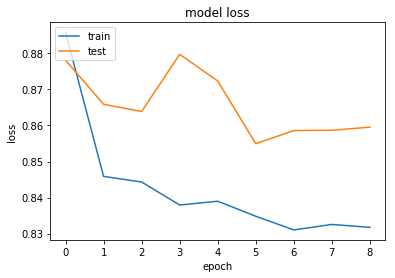

In [49]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Final Model accuracy

In [51]:
predict = model.predict([pad_question_test,pad_sentence_test],verbose=2)
print(prediction_accuracy(predict,single_test_lable)/len(predict))

0.582680591818973
